In [71]:
# Cell 1 – Imports & setup
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid")

PROJ_ROOT = Path.cwd()
while PROJ_ROOT != PROJ_ROOT.parent and not (PROJ_ROOT / "data").exists():
    PROJ_ROOT = PROJ_ROOT.parent

DATA_DIR = PROJ_ROOT / "data" / "processed"
PARQUET_PATH = DATA_DIR / "events.parquet"
CSV_PATH = DATA_DIR / "clean_data.csv"


In [72]:
# Cell 2 – Load processed data (Parquet - fallback to csv)
try:
    df = pd.read_parquet(PARQUET_PATH)
    source_used = PARQUET_PATH
except ImportError as err:
    print("Parquet missing, falling back to CSV:", err)
    df = pd.read_csv(CSV_PATH)
    source_used = CSV_PATH

print(f"Loaded {len(df):,} rows from {source_used}")
df.head()


Loaded 90,189 rows from c:\Users\umyana\Documents\mobile_game_analytics_pipeline\data\processed\events.parquet


,userid,version,session_count,retention_1,retention_7,acquisition_channel,country,platform,purchase,CAC,revenue,ROI
0,116,gate_30,3,False,False,Facebook,USA,Google Play,0,2.8,0.038024,-0.986420
1,337,gate_30,38,True,False,TikTok,USA,Google Play,0,1.7,0.100486,-0.940890
2,377,gate_40,165,True,False,Facebook,USA,Google Play,0,2.8,0.140215,-0.949923
3,483,gate_40,1,False,False,Facebook,Mexico,Google Play,0,2.8,0.019012,-0.993210
4,488,gate_40,179,True,True,TikTok,USA,App Store,0,1.7,1.234440,-0.273859


In [74]:
# Cell 3 – Schema & basic stats
display(df.info())
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   userid               90189 non-null  int64  
 1   version              90189 non-null  object 
 2   session_count        90189 non-null  int64  
 3   retention_1          90189 non-null  bool   
 4   retention_7          90189 non-null  bool   
 5   acquisition_channel  90189 non-null  object 
 6   country              90189 non-null  object 
 7   platform             90189 non-null  object 
 8   purchase             90189 non-null  int64  
 9   CAC                  90189 non-null  float64
 10  revenue              90189 non-null  float64
 11  ROI                  90189 non-null  float64
dtypes: bool(2), float64(3), int64(3), object(4)
memory usage: 7.1+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userid,90189.0,NaN,NaN,NaN,4998412.234496,2883285.6077,116.0,2512230.0,4995815.0,7496452.0,9999861.0
version,90189,2,gate_40,45489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
session_count,90189.0,NaN,NaN,NaN,51.872457,195.050858,0.0,5.0,16.0,51.0,49854.0
retention_1,90189,2,False,50036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retention_7,90189,2,False,73408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acquisition_channel,90189,4,Instagram,36281,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,90189,3,USA,69543,NaN,NaN,NaN,NaN,NaN,NaN,NaN
platform,90189,2,Google Play,67690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
purchase,90189.0,NaN,NaN,NaN,0.055772,0.229482,0.0,0.0,0.0,0.0,1.0
CAC,90189.0,NaN,NaN,NaN,2.125861,0.72223,0.3,1.7,2.3,2.8,2.8


In [75]:
# Cell 4 – Missing values (% of rows per column)
missing_pct = df.isna().mean().sort_values(ascending=False)
missing_pct_df = (missing_pct * 100).to_frame("missing_pct")
missing_pct_df.style.format({"missing_pct": "{:.2f}%"})

,missing_pct
userid,0.00%
version,0.00%
session_count,0.00%
retention_1,0.00%
retention_7,0.00%
acquisition_channel,0.00%
country,0.00%
platform,0.00%
purchase,0.00%
CAC,0.00%


In [76]:
# Cell 5 – Duplicate check on user id
dup_count = df.duplicated(subset="userid").sum()
print(f"Duplicate userid count: {dup_count}")

Duplicate userid count: 0


In [77]:
# Cell 6 – Purchase & retention metrics
metrics = {
    "purchase_rate": df["purchase"].mean(),
    "retention_d1": df.get("retention_1", pd.Series(dtype=float)).mean(),
    "retention_d7": df.get("retention_7", pd.Series(dtype=float)).mean(),
    "retention_d30": df.get("retention_d30", pd.Series(dtype=float)).mean(),
    "mean_sessions": df["session_count"].mean(),
    "median_sessions": df["session_count"].median(),
}
pd.Series(metrics).dropna()

purchase_rate       0.055772
retention_d1        0.445210
retention_d7        0.186065
mean_sessions      51.872457
median_sessions    16.000000
dtype: float64

In [78]:
# Cell 7 – Channel / platform / country mix
channel_mix = df["acquisition_channel"].value_counts(normalize=True) * 100
platform_mix = df["platform"].value_counts(normalize=True) * 100
country_mix = df["country"].value_counts(normalize=True) * 100

display(channel_mix.rename("channel_pct"))
display(platform_mix.rename("platform_pct"))
display(country_mix.rename("country_pct"))

acquisition_channel
Instagram    40.227744
Facebook     29.688765
TikTok       19.934804
Organic      10.148688
Name: channel_pct, dtype: float64

platform
Google Play    75.053499
App Store      24.946501
Name: platform_pct, dtype: float64

country
USA       77.108073
Mexico    13.847587
Brazil     9.044340
Name: country_pct, dtype: float64

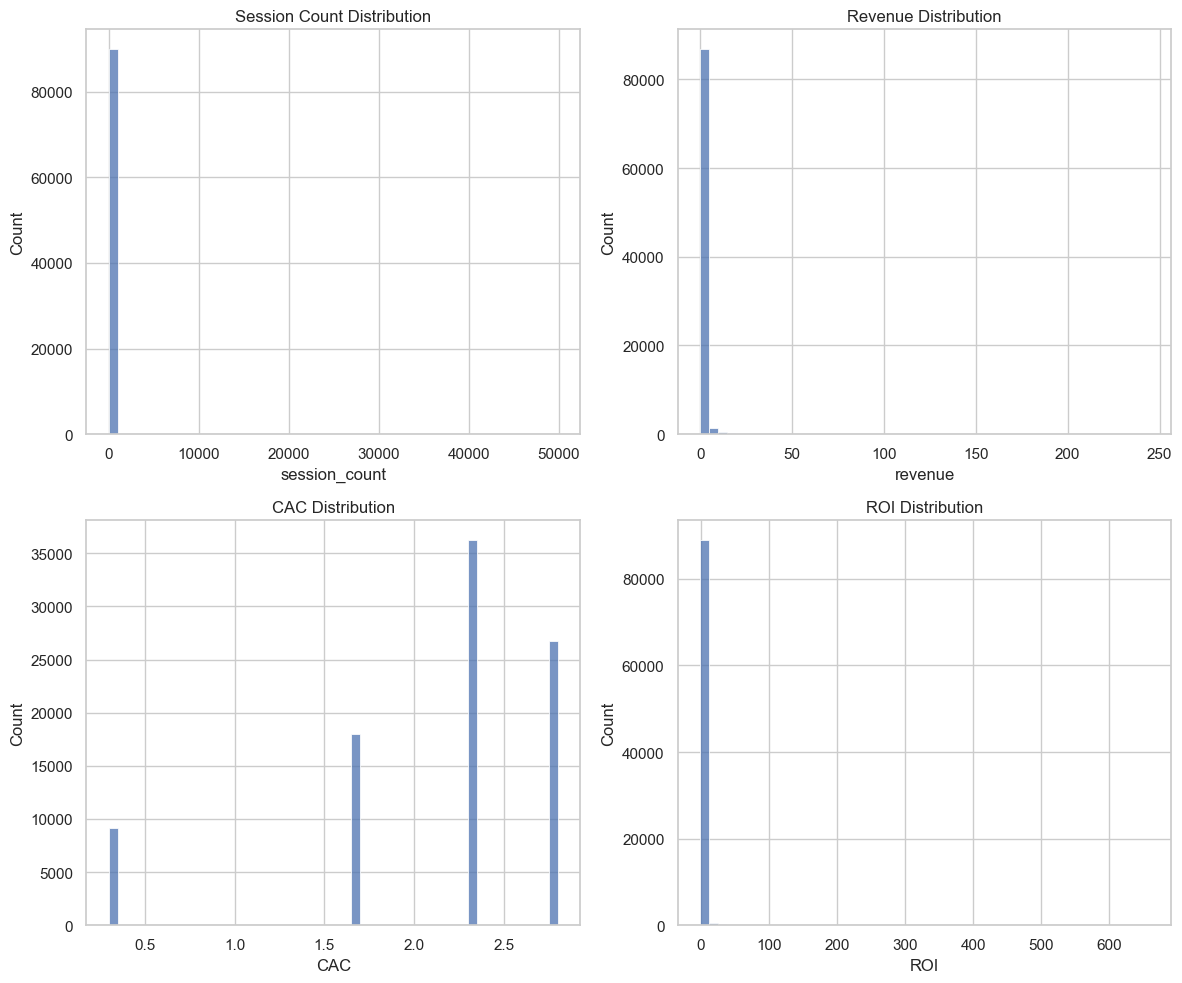

In [79]:
# Cell 8 – Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df["session_count"], bins=50, ax=axes[0, 0])
axes[0, 0].set_title("Session Count Distribution")

sns.histplot(df["revenue"], bins=50, ax=axes[0, 1])
axes[0, 1].set_title("Revenue Distribution")

sns.histplot(df["CAC"], bins=50, ax=axes[1, 0])
axes[1, 0].set_title("CAC Distribution")

sns.histplot(df["ROI"], bins=50, ax=axes[1, 1])
axes[1, 1].set_title("ROI Distribution")

plt.tight_layout()

In [81]:
# Cell 9 – Purchase rate by acquisition channel / platform
purchase_by_channel = (
    df.groupby("acquisition_channel")["purchase"]
    .mean()
    .sort_values(ascending=False)
)
purchase_by_platform = (
    df.groupby("platform")["purchase"]
    .mean()
    .sort_values(ascending=False)
)

display(purchase_by_channel.rename("purchase_rate"))
display(purchase_by_platform.rename("purchase_rate"))

acquisition_channel
Instagram    0.056421
Facebook     0.055535
TikTok       0.055175
Organic      0.055064
Name: purchase_rate, dtype: float64

platform
App Store      0.056491
Google Play    0.055533
Name: purchase_rate, dtype: float64

In [82]:
# Cell 10 – Outlier quick check using z-score on sessions & revenue
from scipy import stats

z_sessions = np.abs(stats.zscore(df["session_count"].astype(float)))
z_revenue = np.abs(stats.zscore(df["revenue"].astype(float)))

outlier_sessions = (z_sessions > 3).sum()
outlier_revenue = (z_revenue > 3).sum()

print(f"Session outliers (>3σ): {outlier_sessions}")
print(f"Revenue outliers (>3σ): {outlier_revenue}")

Session outliers (>3σ): 425
Revenue outliers (>3σ): 1008


In [84]:
# Cell 11 – Summary markdown (fill with findings after running above cells)
from IPython.display import Markdown

summary = """
### Day 1 EDA Summary
- Missing values: {missing_summary}
- Duplicate user ids: {dup_count}
- Purchase rate: {purchase_rate:.2%}
- D1 retention: {retention_d1:.2%}
Notes:
  - CAC updates are keeping ROI at a median level of -0.95; revenue assumptions need to be improved.
  - 0.5% of session outliers are above 3σ; the revenue contribution of high-session users should be re-evaluated.
""".format(
    missing_summary=", ".join(
        f"{col} {pct:.2f}%"
        for col, pct in missing_pct[missing_pct > 0].items()
    )
    or "None",
    dup_count=dup_count,
    purchase_rate=metrics["purchase_rate"],
    retention_d1=metrics["retention_d1"],
)

Markdown(summary)


### Day 1 EDA Summary
- Missing values: None
- Duplicate user ids: 0
- Purchase rate: 5.58%
- D1 retention: 44.52%
Notes:
  - CAC updates are keeping ROI at a median level of -0.95; revenue assumptions need to be improved.
  - 0.5% of session outliers are above 3σ; the revenue contribution of high-session users should be re-evaluated.
